In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint#_adjoint

In [2]:
def sin_trajectory(t):
    return math.sin(t)

In [3]:
def plot_trajectory(trajectory, estimated_trajectory, 
                    generator_function, estimation_function,
                    title):
    plt.figure(figsize=(8, 4))
    plt.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), label=f'{generator_function}(t)')
    plt.plot(estimated_trajectory[:, 0].numpy(), estimated_trajectory[:, 1].numpy(), label=f'{estimation_function}(t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
times = torch.linspace(0, 2 * math.pi, steps=100)
values = torch.tensor([sin_trajectory(t.item()) for t in times])
trajectory = torch.stack([times, values], dim=1)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim + 1] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)
	
	def forward(self, t, x):
		state = torch.cat([t.unsqueeze(0), x], dim=0)
		x_dot = self.mlp(state)
		return x_dot

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
ode = ODE(2, (256 for _ in range(3))).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 6.992776870727539
Epoch 2, Loss: 6.59893274307251
Epoch 3, Loss: 6.222782611846924
Epoch 4, Loss: 5.864675998687744
Epoch 5, Loss: 5.5391387939453125
Epoch 6, Loss: 5.237081050872803
Epoch 7, Loss: 4.947283744812012
Epoch 8, Loss: 4.664450645446777
Epoch 9, Loss: 4.390380859375
Epoch 10, Loss: 4.1253581047058105
Epoch 11, Loss: 3.8704674243927
Epoch 12, Loss: 3.6238996982574463
Epoch 13, Loss: 3.385399103164673
Epoch 14, Loss: 3.155350923538208
Epoch 15, Loss: 2.930593729019165
Epoch 16, Loss: 2.7104570865631104
Epoch 17, Loss: 2.4960498809814453
Epoch 18, Loss: 2.285040855407715
Epoch 19, Loss: 2.0802230834960938
Epoch 20, Loss: 1.883219838142395
Epoch 21, Loss: 1.695928931236267
Epoch 22, Loss: 1.5190757513046265
Epoch 23, Loss: 1.353070616722107
Epoch 24, Loss: 1.1979137659072876
Epoch 25, Loss: 1.0556855201721191
Epoch 26, Loss: 0.9280180335044861
Epoch 27, Loss: 0.8167153596878052
Epoch 28, Loss: 0.7229974269866943
Epoch 29, Loss: 0.6485825777053833
Epoch 30, Loss: 

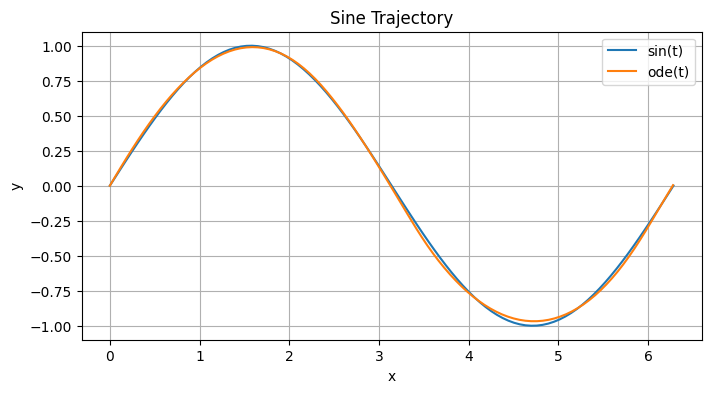

In [8]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')